In [1]:
import torch 
import torch.nn as nn
import glob
import numpy as np
import cv2 
import time
from numpy import moveaxis

from torch.utils.data import Dataset

import torchvision
import torch.optim as optim

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
INPUT_FOLDER = "../input/JPEGImages/"
BATCH_SIZE = 32
WORKERS = 4

In [3]:
%ls -1 "../input/JPEGImages/" | wc -l

5011


In [4]:
TOTAL_IMAGES = len(glob.glob(INPUT_FOLDER + "*"))
VALIDATION = slice(0, 1000)
TRAINING = slice(1000, TOTAL_IMAGES)
SMALL_VALIDATION = slice(0, 100)
SMALL_TARINING = slice(1000, 1500)

In [5]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print(f"CUDA is available! Training on {torch.cuda.get_device_name(0)}...")
    device = torch.device("cuda:0")
else:
    print("CUDA is not available. Training on CPU...")
    device = 'cpu'

CUDA is available! Training on Tesla K80...


In [6]:
class VOCDataset(Dataset):
    def __init__(self, subset_indexes, transforms=None):
        super().__init__()
        self.transforms = transforms
        self.files = glob.glob(INPUT_FOLDER + "*")[subset_indexes]

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image_path = self.files[idx]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lr = cv2.resize(img, (72, 72)) 
        mr = cv2.resize(img, (144, 144)) 
        hr = cv2.resize(img, (288, 288))
        return lr, mr, hr, moveaxis(lr, 2, 0), moveaxis(mr, 2, 0), moveaxis(hr, 2, 0)

In [7]:
validation_ds = VOCDataset(subset_indexes=VALIDATION)
training_ds = VOCDataset(subset_indexes=TRAINING)
small_training_ds = VOCDataset(subset_indexes=SMALL_VALIDATION)
small_validation_ds = VOCDataset(subset_indexes=SMALL_TARINING)

In [8]:
train_loader = torch.utils.data.DataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

small_train_loader = torch.utils.data.DataLoader(small_training_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
small_val_loader = torch.utils.data.DataLoader(small_validation_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [9]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [10]:
# will need channels-last <> channels-first transformation
print(training_ds[10][1].shape)
# channels-last to chanels                 
moveaxis(training_ds[10][1], 2, 0).shape

(144, 144, 3)


(3, 144, 144)

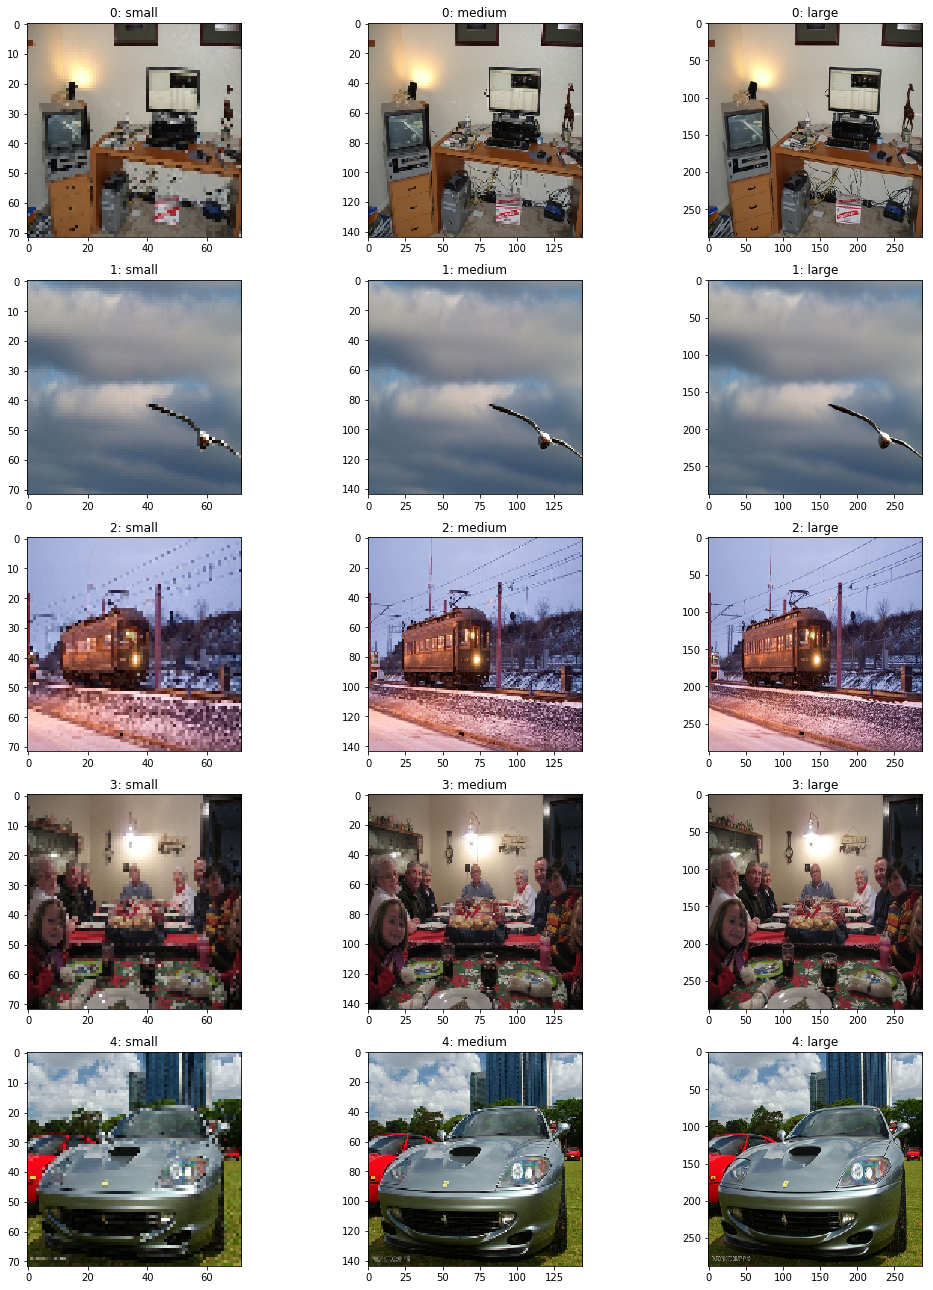

In [11]:
nrows, ncols = 5, 3
figsize = [15, 18] 

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for i, axi in enumerate(ax.flat):
    img = training_ds[i//3][i%3]
    axi.imshow(img)
    axi.set_title(f"{i//3}: {'small' if i%3==0 else 'medium' if i%3==1 else 'large'}")
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

In [41]:
def check_image(model, image_id, version=1):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[10, 10] )
    
    if version == 1:
        images = [training_ds[image_id][0], training_ds[image_id][1]]
        titles = ["original lr", "original mr", "predicted mr"]
    else:
        images = [training_ds[image_id][0], training_ds[image_id][2]]
        titles = ["original lr", "original hr", "predicted mr", "predicted hr"]
    
    res = model(torch.Tensor(np.expand_dims(training_ds[image_id][3], 0)).float().to(device))
    if version == 1:
        images.append(np.clip(moveaxis(res.cpu().detach().numpy()[0], 0, 2).astype(int), 0, 255))
    else:
        images.append(np.clip(moveaxis(res[0].cpu().detach().numpy()[0], 0, 2).astype(int), 0, 255))
        images.append(np.clip(moveaxis(res[1].cpu().detach().numpy()[0], 0, 2).astype(int), 0, 255))

    for i, axi in enumerate(ax.flat):
        if len(titles) > i:
            axi.imshow(images[i], alpha=0.99)
            axi.set_title(titles[i])

    plt.tight_layout(True)
    plt.show()


    
def train(tr_loader, model, criterion, optimizer, device, version=1, mr_hr_loss_ratio=0.5):
    """
    mr_hr_loss_ratio - 0.5 = 50:50 mr and hr, 0.3 = 30:mr, 70:hr, 1 = check hr only
    """    
    model.train()
    
    tr_loss = 0
    for i, (lr_img, mr_img, hr_img, lr_img_cf, mr_img_cf, hr_img_cf) in enumerate(tr_loader):
        
        # Move to default device
        lr_img = lr_img_cf.float().to(device)  # (batch_size (N), 3, 72, 72)        
        mr_img = mr_img_cf.float().to(device)  # (batch_size (N), 3, 144, 144)
        hr_img = hr_img_cf.float().to(device)  # (batch_size (N), 3, 288, 288)
        
        # Forward prop. + Loss
        if version == 1:
            output = model(lr_img)
            loss = criterion(output, mr_img)
        elif version == 2:
            out_mr, out_hr = model(lr_img)
            loss = criterion(out_mr, mr_img) * mr_hr_loss_ratio + criterion(out_hr, hr_img) * (1 - mr_hr_loss_ratio)

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()
        
        # Update model
        optimizer.step()
        
        # Keep track of loss
        tr_loss += loss.item()

    return tr_loss


def test(val_loader, model, criterion, device, version=1, mr_hr_loss_ratio=0.5):
    
    model.eval()
    
    val_loss = 0
    psnr = 0
    ssim = 0
    
    with torch.no_grad():
        for i, (lr_img, mr_img, hr_img, lr_img_cf, mr_img_cf, hr_img_cf) in enumerate(val_loader):

            lr_img = lr_img_cf.float().to(device)  # (batch_size (N), 3, 72, 72)        
            mr_img = mr_img_cf.float().to(device)  # (batch_size (N), 3, 144, 144)
            hr_img = hr_img_cf.float().to(device)  # (batch_size (N), 3, 288, 288)
            
            if version == 1:
                out_mr = model(lr_img)
                loss = criterion(out_mr, mr_img)
                out_mr = np.clip(moveaxis(out_mr.cpu().numpy(), 1, 3), 0, 255)
                mr_img = np.clip(moveaxis(mr_img.cpu().numpy(), 1, 3), 0, 255)
                
                for pred_mr, gt_mr in zip(out_mr, mr_img):
                    psnr += peak_signal_noise_ratio(pred_mr, gt_mr, data_range=255.)
                    ssim += structural_similarity(pred_mr, gt_mr, data_range=255., multichannel=True)
            
            elif version == 2:
                out_mr, out_hr = model(lr_img)
                loss = criterion(out_mr, mr_img) * (mr_hr_loss_ratio) + criterion(out_hr, hr_img) * (1 - mr_hr_loss_ratio)
                out_hr = np.clip(moveaxis(out_hr.cpu().numpy(), 1, 3), 0, 255)
                hr_img = np.clip(moveaxis(hr_img.cpu().numpy(), 1, 3), 0, 255)
                
                for pred_hr, gt_hr in zip(out_hr, hr_img):
                    psnr += peak_signal_noise_ratio(pred_hr, gt_hr, data_range=255.)
                    ssim += structural_similarity(pred_hr, gt_hr, data_range=255., multichannel=True)
            
            else: raise("Not supported verson")
            
            val_loss += loss.item()
            
    return val_loss, psnr, ssim



def single_step(tr_loader, val_loader, model, criterion, optimizer, device, epoch, version=1, mr_hr_loss_ratio=0.5):

    start = time.time()
    training_log = []
    
    
    tr_loss = train(tr_loader, model, criterion, optimizer, device, version, mr_hr_loss_ratio)
    
    val_loss, psnr, ssim = test(val_loader, model, criterion, device, version, mr_hr_loss_ratio)
    
    res = {
        "epoch": epoch, 
        "train_loss": round(tr_loss / len(tr_loader), 3),
        "val_loss": round(val_loss / len(val_loader), 3),
        "time": round(time.time() - start, 3),
        "PSNRs": round(psnr / len(val_loader), 3),
        "SSIMs": round(ssim / len(val_loader), 3),
    }
    print(res)
    training_log.append(res)

    return training_log

In [13]:
class Step2Model(nn.Module):
    def __init__(self):
        super(Step2Model, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(64, 3, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):        
        x = self.relu(self.conv1(x))      # (N), 3, 72, 72    -> (N), 64, 72, 72
        x = self.relu(self.conv2(x))      # (N), 64, 72, 72   -> (N), 64, 72, 72
        x = self.relu(self.upsampling(x)) # (N), 64, 72, 72   -> (N), 64, 144, 144
        x = self.relu(self.conv3(x))      # (N), 64, 144, 144 -> (N), 3, 144, 144
        return x

model = Step2Model()
model.to(device)

Step2Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsampling): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

In [14]:
model = Step2Model()
model.load_state_dict(torch.load('../models/step2_100_steps.tar'))
model.to(device)

Step2Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsampling): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

In [15]:
criterion = nn.MSELoss().to(device)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [26]:
num_epochs = 10

In [27]:
for epoch in range(num_epochs):
    log = single_step(train_loader, val_loader, 
                      model, criterion, optimizer, device, 
                      epoch, version=1, mr_hr_loss_ratio=0.5)

{'epoch': 0, 'train_loss': 459.349, 'val_loss': 448.345, 'time': 22.543, 'PSNRs': 359.252, 'SSIMs': 10.831}
{'epoch': 1, 'train_loss': 459.373, 'val_loss': 448.563, 'time': 22.343, 'PSNRs': 359.212, 'SSIMs': 10.825}
{'epoch': 2, 'train_loss': 459.241, 'val_loss': 448.916, 'time': 22.334, 'PSNRs': 359.14, 'SSIMs': 10.848}
{'epoch': 3, 'train_loss': 459.401, 'val_loss': 448.7, 'time': 22.872, 'PSNRs': 359.112, 'SSIMs': 10.793}
{'epoch': 4, 'train_loss': 459.46, 'val_loss': 449.211, 'time': 22.373, 'PSNRs': 358.991, 'SSIMs': 10.847}
{'epoch': 5, 'train_loss': 459.395, 'val_loss': 448.262, 'time': 22.098, 'PSNRs': 359.203, 'SSIMs': 10.793}
{'epoch': 6, 'train_loss': 459.371, 'val_loss': 449.648, 'time': 23.417, 'PSNRs': 358.951, 'SSIMs': 10.87}
{'epoch': 7, 'train_loss': 459.241, 'val_loss': 447.996, 'time': 22.387, 'PSNRs': 359.345, 'SSIMs': 10.836}
{'epoch': 8, 'train_loss': 459.546, 'val_loss': 448.25, 'time': 22.22, 'PSNRs': 359.355, 'SSIMs': 10.856}
{'epoch': 9, 'train_loss': 459.407,

In [28]:
torch.save(model.state_dict(), '../models/step2_100_steps.tar')

In [29]:
model = Step2Model()
model.load_state_dict(torch.load('../models/step2_100_steps.tar'))
model.to(device)

Step2Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsampling): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

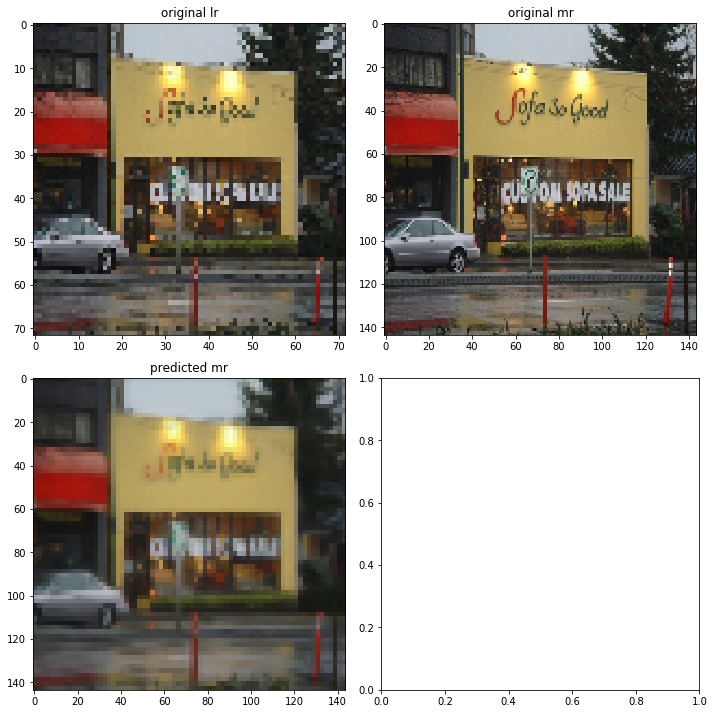

In [31]:
check_image(model, 144)

In [32]:
class Step3Model(nn.Module):
    def __init__(self):
        super(Step3Model, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(64, 3, 1)
        self.conv4 = nn.Conv2d(64, 3, 1)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):        
        x = self.relu(self.conv1(x))  # (N), 3, 72, 72    -> (N), 64, 72, 72
        x = self.relu(self.conv2(x))  # (N), 64, 72, 72   -> (N), 64, 72, 72
        x = self.relu(self.up1(x))    # (N), 64, 72, 72   -> (N), 64, 144, 144
        y = self.relu(self.up2(x))    # (N), 64, 144, 144 -> (N), 64, 288, 288
        x = self.relu(self.conv3(x))  # (N), 64, 144, 144 -> (N), 3, 144, 144
        y = self.relu(self.conv4(y))  # (N), 64, 288, 288 -> (N), 3, 288, 288
        return x, y

model = Step3Model()
model.to(device)

Step3Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): Upsample(scale_factor=2.0, mode=nearest)
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

In [33]:
criterion = nn.MSELoss().to(device)

In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
num_epochs = 50

In [48]:
train_loader = torch.utils.data.DataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [49]:
for epoch in range(num_epochs):
    log = single_step(train_loader, val_loader, 
                      model, criterion, optimizer, device, 
                      epoch, version=2, mr_hr_loss_ratio=0.5)

{'epoch': 0, 'train_loss': 472.386, 'val_loss': 456.83, 'time': 52.921, 'PSNRs': 357.389, 'SSIMs': 9.762}
{'epoch': 1, 'train_loss': 473.561, 'val_loss': 456.582, 'time': 52.198, 'PSNRs': 357.422, 'SSIMs': 9.74}
{'epoch': 2, 'train_loss': 474.716, 'val_loss': 455.51, 'time': 52.368, 'PSNRs': 357.558, 'SSIMs': 9.743}
{'epoch': 3, 'train_loss': 468.269, 'val_loss': 456.435, 'time': 52.556, 'PSNRs': 357.088, 'SSIMs': 9.78}
{'epoch': 4, 'train_loss': 473.935, 'val_loss': 470.282, 'time': 52.37, 'PSNRs': 353.914, 'SSIMs': 9.712}
{'epoch': 5, 'train_loss': 470.097, 'val_loss': 455.229, 'time': 52.632, 'PSNRs': 357.696, 'SSIMs': 9.773}
{'epoch': 6, 'train_loss': 469.816, 'val_loss': 455.254, 'time': 52.398, 'PSNRs': 357.592, 'SSIMs': 9.766}
{'epoch': 7, 'train_loss': 468.851, 'val_loss': 455.128, 'time': 52.104, 'PSNRs': 357.617, 'SSIMs': 9.799}
{'epoch': 8, 'train_loss': 467.257, 'val_loss': 453.374, 'time': 51.598, 'PSNRs': 358.02, 'SSIMs': 9.8}
{'epoch': 9, 'train_loss': 471.989, 'val_loss

In [50]:
torch.save(model.state_dict(), '../models/step3_100_steps.tar')

In [51]:
model = Step3Model()
model.load_state_dict(torch.load('../models/step3_100_steps.tar'))
model.to(device)

Step3Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): Upsample(scale_factor=2.0, mode=nearest)
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

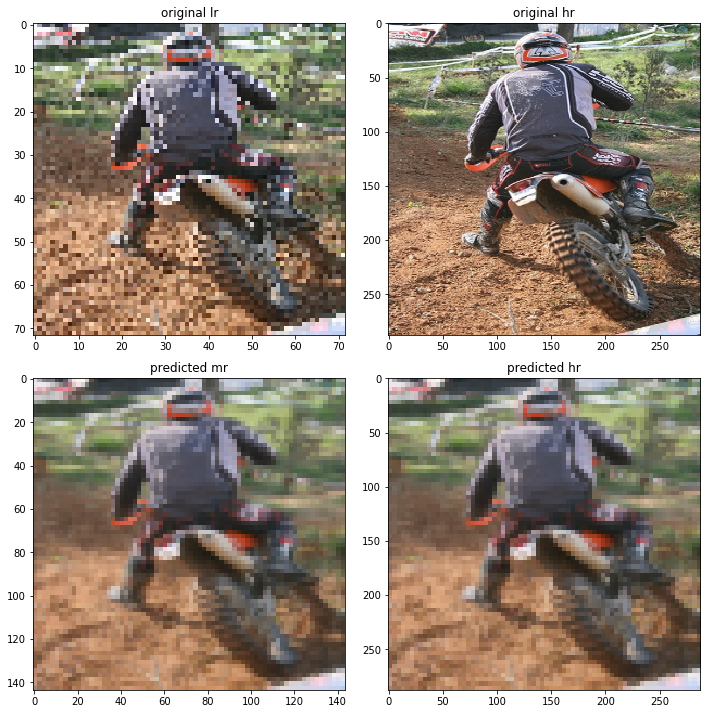

In [53]:
check_image(model, 2324, version=2)

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, kernel_size=3, n_channels=32):
        super(ResidualBlock, self).__init__()
        self.conv_block1 = nn.Conv2d(
            in_channels=n_channels, 
            out_channels=n_channels, 
            kernel_size=kernel_size,
            padding=1)
        self.conv_block2 = nn.Conv2d(
            in_channels=n_channels, 
            out_channels=n_channels, 
            kernel_size=kernel_size,
            padding=1)

    def forward(self, _input):
        residual = _input                  # (N, 32, 72, 72)
        output = self.conv_block1(_input)  # (N, 32, 72, 72)
        output = self.conv_block2(output)  # (N, 32, 72, 72)
        output = output + residual         # (N, 32, 72, 72)
        return output


class Step4Model(nn.Module):
    def __init__(self, kernel_size=3, n_channels=32):
        super(Step4Model, self).__init__()
        self.first_conv_block = nn.Conv2d(3, n_channels, kernel_size=kernel_size, padding=1)
        self.residual_block1 = ResidualBlock(kernel_size=kernel_size, n_channels=n_channels)
        self.residual_block2 = ResidualBlock(kernel_size=kernel_size, n_channels=n_channels)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(32, 3, 1)
        self.residual_block3 = ResidualBlock(kernel_size=kernel_size, n_channels=n_channels)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(32, 3, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):        
        x = self.relu(self.first_conv_block(x))         # (N), 3, 72, 72    -> (N), 32, 72, 72
        x = self.relu(self.residual_block1(x))          # (N), 32, 72, 72   -> (N), 32, 72, 72
        x = self.relu(self.residual_block2(x))          # (N), 32, 72, 72   -> (N), 32, 72, 72
        x = self.relu(self.up1(x))                      # (N), 32, 72, 72   -> (N), 32, 144, 144
        y = self.relu(self.residual_block3(x))          # (N), 32, 144, 144 -> (N), 32, 144, 144
        x = self.relu(self.conv3(x))                    # (N), 32, 72, 72   -> (N), 3, 144, 144
        y = self.relu(self.up2(y))                      # (N), 32, 144, 144 -> (N), 32, 288, 288
        y = self.relu(self.conv4(y))                    # (N), 32, 288, 288 -> (N), 3, 288, 288

        return x, y

model = Step4Model()
model.to(device)

Step4Model(
  (first_conv_block): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual_block1): ResidualBlock(
    (conv_block1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (residual_block2): ResidualBlock(
    (conv_block1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (up1): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (residual_block3): ResidualBlock(
    (conv_block1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

In [58]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss().to(device)

In [59]:
num_epochs = 10

In [60]:
train_loader = torch.utils.data.DataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [61]:
for epoch in range(num_epochs):
    log = single_step(train_loader, val_loader, 
                      model, criterion, optimizer, device, 
                      epoch, version=2, mr_hr_loss_ratio=0.5)

{'epoch': 0, 'train_loss': 4861.647, 'val_loss': 4821.127, 'time': 63.345, 'PSNRs': 185.738, 'SSIMs': 5.011}
{'epoch': 1, 'train_loss': 4855.113, 'val_loss': 4825.934, 'time': 63.34, 'PSNRs': 185.463, 'SSIMs': 5.008}
{'epoch': 2, 'train_loss': 4855.881, 'val_loss': 4821.093, 'time': 63.189, 'PSNRs': 185.642, 'SSIMs': 5.01}
{'epoch': 3, 'train_loss': 4860.189, 'val_loss': 4832.467, 'time': 63.452, 'PSNRs': 185.562, 'SSIMs': 5.015}
{'epoch': 4, 'train_loss': 4855.877, 'val_loss': 4817.773, 'time': 62.653, 'PSNRs': 185.783, 'SSIMs': 5.01}
{'epoch': 5, 'train_loss': 4856.652, 'val_loss': 4819.498, 'time': 63.64, 'PSNRs': 185.753, 'SSIMs': 5.02}
{'epoch': 6, 'train_loss': 4853.444, 'val_loss': 4823.119, 'time': 63.755, 'PSNRs': 185.586, 'SSIMs': 5.022}


KeyboardInterrupt: 

In [50]:
torch.save(model.state_dict(), '../models/step4_small.tar')

In [35]:
model = Step4Model()
model.load_state_dict(torch.load('../models/step4_100_epochs.tar'))
model.to(device)

Step4Model(
  (first_conv_block): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residual_block1): ResidualBlock(
    (conv_block1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (residual_block2): ResidualBlock(
    (conv_block1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (up1): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (residual_block3): ResidualBlock(
    (conv_block1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

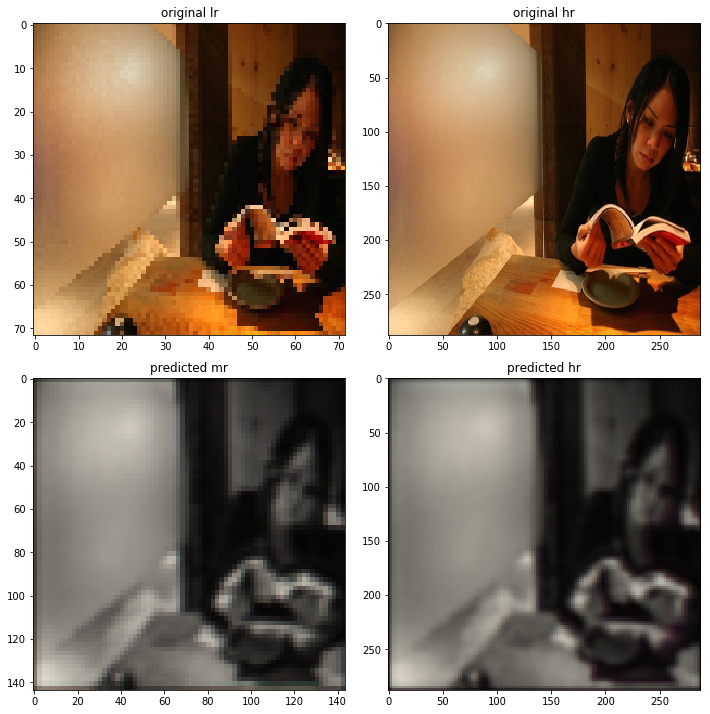

In [49]:
check_image(model, 1244, version=2)

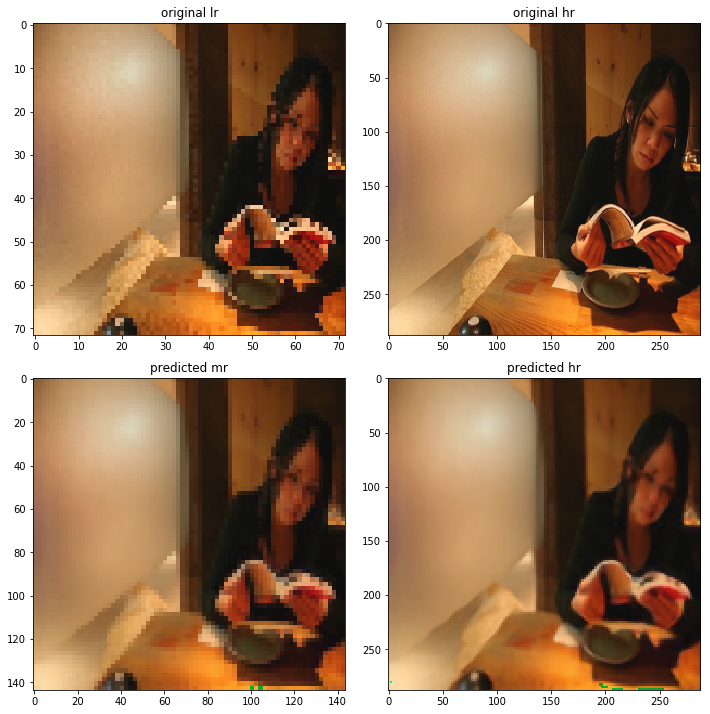

In [89]:
check_image(model, 1244, version=2)

In [62]:
class AtrousBlock(nn.Module):
    def __init__(self, kernel_size=3, n_channels=32):
        super(AtrousBlock, self).__init__()
        
        self.conv_block1 = nn.Conv2d(
            in_channels=n_channels, 
            out_channels=n_channels, 
            kernel_size=kernel_size,
            dilation=1, padding=1)
        
        self.conv_block2 = nn.Conv2d(
            in_channels=n_channels, 
            out_channels=n_channels, 
            kernel_size=kernel_size,
            dilation=2, padding=2)
        
        self.conv_block3 = nn.Conv2d(
            in_channels=n_channels, 
            out_channels=n_channels, 
            kernel_size=kernel_size,
            dilation=4, padding=4)
        
        self.conv_block4 = nn.Conv2d(
            in_channels=96, 
            out_channels=32, 
            kernel_size=kernel_size,
            padding=1)

        self.relu = nn.ReLU()

    def forward(self, _input):
        out1 = self.conv_block1(_input) 
        out2 = self.conv_block2(_input) 
        out3 = self.conv_block3(_input)
        output = self.relu(torch.cat([out1, out2, out3], 1))
        output = self.conv_block4(output)
        return output


class Step5Model(nn.Module):
    def __init__(self, kernel_size=3, n_channels=32):
        super(Step5Model, self).__init__()
        self.first_conv_block = nn.Conv2d(3, n_channels, kernel_size=kernel_size, padding=1)
        self.atrous1 = AtrousBlock(kernel_size=kernel_size, n_channels=n_channels)
        self.atrous2 = AtrousBlock(kernel_size=kernel_size, n_channels=n_channels)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(32, 3, 1)
        self.atrous3 = AtrousBlock(kernel_size=kernel_size, n_channels=n_channels)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(32, 3, 1)
        self.relu = nn.ReLU()

    def forward(self, x):        
        x = self.relu(self.first_conv_block(x))         # (N), 3, 72, 72    -> (N), 32, 72, 72
        x = self.relu(self.atrous1(x))                  # (N), 32, 72, 72   -> (N), 32, 72, 72
        x = self.relu(self.atrous2(x))                  # (N), 32, 72, 72   -> (N), 32, 72, 72
        x = self.relu(self.up1(x))                      # (N), 32, 72, 72   -> (N), 32, 144, 144
        y = self.relu(self.atrous3(x))                  # (N), 32, 144, 144 -> (N), 32, 144, 144
        x = self.relu(self.conv3(x))                    # (N), 32, 72, 72   -> (N), 3, 144, 144
        y = self.relu(self.up2(y))                      # (N), 32, 144, 144 -> (N), 32, 288, 288
        y = self.relu(self.conv4(y))                    # (N), 32, 288, 288 -> (N), 3, 288, 288

        return x, y

model = Step5Model()
model.to(device)

Step5Model(
  (first_conv_block): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (atrous1): AtrousBlock(
    (conv_block1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (conv_block3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (conv_block4): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (atrous2): AtrousBlock(
    (conv_block1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_block2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (conv_block3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (conv_block4): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (up1): Upsample(scale_factor=2.0, mode=nearest)
  (co

In [63]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = rmse
criterion = nn.MSELoss().to(device)

In [83]:
num_epochs = 20

In [84]:
train_loader = torch.utils.data.DataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [85]:
for epoch in range(num_epochs):
    log = single_step(train_loader, val_loader, 
                      model, criterion, optimizer, device, 
                      epoch, version=2, mr_hr_loss_ratio=0.5)

{'epoch': 0, 'train_loss': 493.295, 'val_loss': 463.62, 'time': 144.951, 'PSNRs': 359.096, 'SSIMs': 9.719}
{'epoch': 1, 'train_loss': 475.074, 'val_loss': 455.978, 'time': 145.852, 'PSNRs': 360.042, 'SSIMs': 9.879}
{'epoch': 2, 'train_loss': 472.426, 'val_loss': 446.27, 'time': 147.766, 'PSNRs': 363.422, 'SSIMs': 9.956}
{'epoch': 3, 'train_loss': 457.281, 'val_loss': 441.594, 'time': 146.536, 'PSNRs': 364.332, 'SSIMs': 10.006}
{'epoch': 4, 'train_loss': 458.687, 'val_loss': 441.561, 'time': 147.972, 'PSNRs': 364.037, 'SSIMs': 10.019}
{'epoch': 5, 'train_loss': 453.982, 'val_loss': 437.054, 'time': 149.034, 'PSNRs': 365.74, 'SSIMs': 10.058}
{'epoch': 6, 'train_loss': 455.626, 'val_loss': 437.994, 'time': 146.961, 'PSNRs': 364.998, 'SSIMs': 10.082}
{'epoch': 7, 'train_loss': 452.282, 'val_loss': 439.503, 'time': 147.306, 'PSNRs': 364.307, 'SSIMs': 10.031}
{'epoch': 8, 'train_loss': 445.969, 'val_loss': 435.117, 'time': 147.31, 'PSNRs': 365.269, 'SSIMs': 10.068}
{'epoch': 9, 'train_loss':

In [81]:
torch.save(model.state_dict(), '../models/step5_small.tar') # 'train_loss': 594.229, 'val_loss': 629.418, 'time': 18.857, 'PSNRs': 320.965, 'SSIMs': 9.121}

In [88]:
torch.save(model.state_dict(), '../models/step5_big.tar') # 'train_loss': 445.133, 'val_loss': 427.263, 'time': 146.027, 'PSNRs': 367.524, 'SSIMs': 10.166}

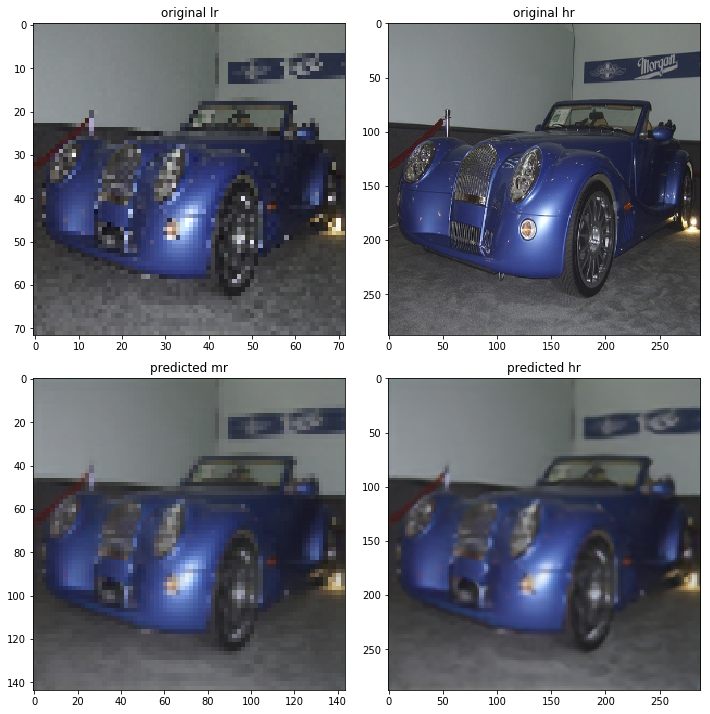

In [87]:
check_image(model, 444, version=2)

In [13]:
r = torchvision.models.vgg16(pretrained=True)
net = nn.Sequential(*[r.features.__getattr__(i) for i in list(map(str, range(3)))])

In [14]:
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [15]:
class Step6Model(nn.Module):
    def __init__(self, kernel_size=3, n_channels=64):
        super(Step6Model, self).__init__()
        r = torchvision.models.vgg16(pretrained=True)
        self.vgg = nn.Sequential(*[r.features.__getattr__(i) for i in list(map(str, range(3)))])
        for param in self.vgg.parameters():
              param.requires_grad = False
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(n_channels, n_channels, 1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(128, 3, 1)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(3, 3, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        vgg_out = self.vgg(x)            # (N), 3, 72, 72     -> (N), 64, 72, 72
        x = self.relu(self.conv1(x))     # (N), 3, 72, 72     -> (N), 64, 72, 72
        x = self.relu(self.conv2(x))     # (N), 64, 72, 72    -> (N), 64, 72, 72
        x = torch.cat([vgg_out, x], 1)   #                    -> (N), 128, 72, 72
        x = self.relu(x)
        x = self.relu(self.up1(x))       # (N), 128, 72, 72   -> (N), 128, 144, 144
        y = self.relu(self.conv3(x))     # (N), 128, 144, 144 -> (N), 3, 144, 144
        x = self.relu(self.up2(y))       # (N), 3, 144, 144   -> (N), 3, 288, 288
        x = self.relu(self.conv4(x))     # (N), 3, 288, 288   -> (N), 3, 288, 288

        return y, x



In [16]:
model = Step6Model()
model.load_state_dict(torch.load('../models/step6_after_unfreeze.tar'))
model.to(device)

Step6Model(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (up1): Upsample(scale_factor=2.0, mode=nearest)
  (conv3): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
  (up2): Upsample(scale_factor=2.0, mode=nearest)
  (conv4): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.MSELoss().to(device)

In [18]:
num_epochs = 10

In [19]:
train_loader = torch.utils.data.DataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [106]:
# torch.save(model.state_dict(), '../models/step6_30_epochs.tar')

In [20]:
for param in model.vgg.parameters():
    param.requires_grad = True

In [ ]:
for epoch in range(num_epochs):
    log = single_step(train_loader, val_loader, 
                      model, criterion, optimizer, device, 
                      epoch, version=2, mr_hr_loss_ratio=0.3)

In [251]:
torch.save(model.state_dict(), '../models/step6_after_unfreeze.tar')

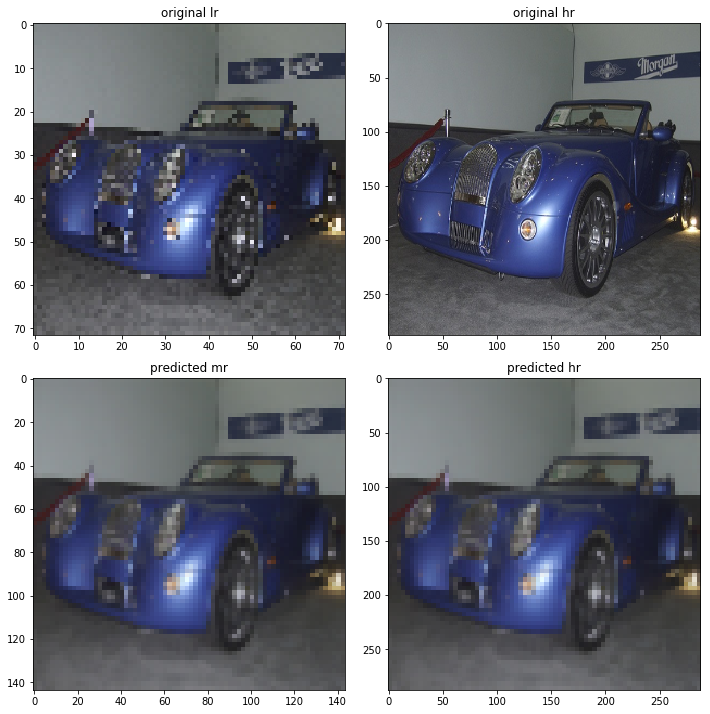

In [104]:
check_image(model, 444, version=2)

In [22]:
class Step7Model(nn.Module):
    def __init__(self, kernel_size=3, n_channels=64):
        super(Step7Model, self).__init__()
        r = torchvision.models.vgg16(pretrained=True)
        self.vgg = nn.Sequential(*[r.features.__getattr__(i) for i in list(map(str, range(3)))])
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(n_channels, n_channels, 1)
        self.up1 = nn.PixelShuffle(2)
        self.conv3 = nn.Conv2d(32, 3, 1)
        self.up2 = nn.PixelShuffle(2)
        self.conv4 = nn.Conv2d(8, 3, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        vgg_out = self.vgg(x)            # (N), 3, 72, 72     -> (N), 64, 72, 72
        x = self.relu(self.conv1(x))     # (N), 3, 72, 72     -> (N), 64, 72, 72
        x = self.relu(self.conv2(x))     # (N), 64, 72, 72    -> (N), 64, 72, 72
        x = torch.cat([vgg_out, x], 1)   #                    -> (N), 128, 72, 72
        x = self.relu(x)
        x = self.relu(self.up1(x))       # (N), 128, 72, 72   -> (N), 32, 144, 144
        mr = self.relu(self.conv3(x))     # (N), 32, 144, 144 -> (N), 3, 144, 144
        x = self.relu(self.up2(x))       # (N), 32, 144, 144  -> (N), 8, 288, 288
        hr = self.relu(self.conv4(x))     # (N), 8, 288, 288  -> (N), 3, 288, 288
        return mr, hr

model = Step7Model()
model.to(device)

Step7Model(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (up1): PixelShuffle(upscale_factor=2)
  (conv3): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (up2): PixelShuffle(upscale_factor=2)
  (conv4): Conv2d(8, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

In [23]:
model = Step7Model()

In [20]:
model.load_state_dict(torch.load('../models/step7_50_epochs.tar'))

<All keys matched successfully>

In [24]:
model.to(device)

Step7Model(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (up1): PixelShuffle(upscale_factor=2)
  (conv3): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (up2): PixelShuffle(upscale_factor=2)
  (conv4): Conv2d(8, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
)

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss().to(device)

In [43]:
num_epochs = 10

In [44]:
train_loader = torch.utils.data.DataLoader(training_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = torch.utils.data.DataLoader(validation_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [46]:
for epoch in range(num_epochs):
    log = single_step(train_loader, val_loader, 
                      model, criterion, optimizer, device, 
                      epoch, version=2, mr_hr_loss_ratio=0.3)

{'epoch': 0, 'train_loss': 387.337, 'val_loss': 379.615, 'time': 42.239, 'PSNRs': 735.776, 'SSIMs': 20.847}
{'epoch': 1, 'train_loss': 387.437, 'val_loss': 379.524, 'time': 42.217, 'PSNRs': 735.735, 'SSIMs': 20.839}
{'epoch': 2, 'train_loss': 386.995, 'val_loss': 379.43, 'time': 41.655, 'PSNRs': 735.906, 'SSIMs': 20.859}
{'epoch': 3, 'train_loss': 386.786, 'val_loss': 379.461, 'time': 41.009, 'PSNRs': 735.882, 'SSIMs': 20.854}
{'epoch': 4, 'train_loss': 386.789, 'val_loss': 379.439, 'time': 42.064, 'PSNRs': 735.873, 'SSIMs': 20.848}
{'epoch': 5, 'train_loss': 387.071, 'val_loss': 379.371, 'time': 41.076, 'PSNRs': 735.88, 'SSIMs': 20.851}
{'epoch': 6, 'train_loss': 386.133, 'val_loss': 380.291, 'time': 41.244, 'PSNRs': 735.522, 'SSIMs': 20.828}
{'epoch': 7, 'train_loss': 387.0, 'val_loss': 379.743, 'time': 41.523, 'PSNRs': 735.594, 'SSIMs': 20.856}
{'epoch': 8, 'train_loss': 386.586, 'val_loss': 379.354, 'time': 42.352, 'PSNRs': 735.877, 'SSIMs': 20.85}
{'epoch': 9, 'train_loss': 386.67

In [307]:
torch.save(model.state_dict(), '../models/step7_50_epochs.tar')

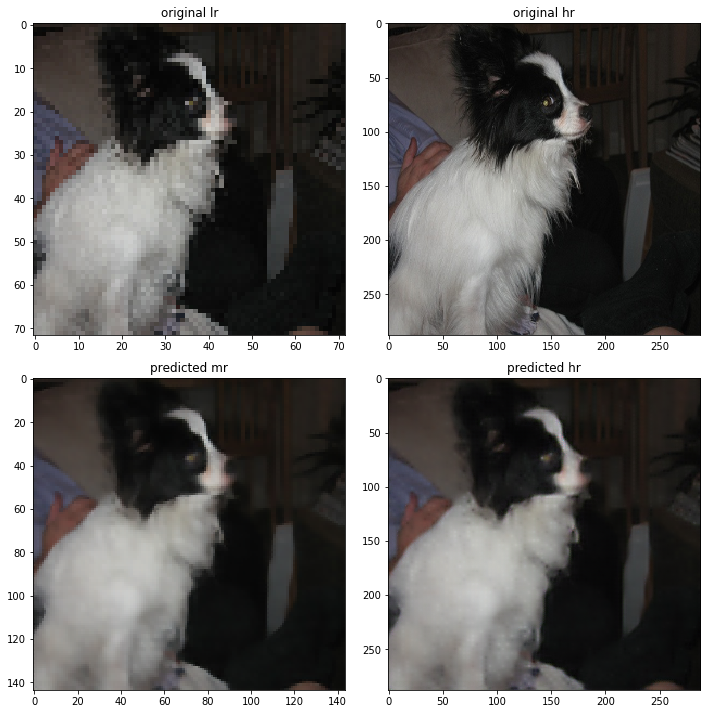

In [47]:
check_image(model, 2233, version=2)

In [50]:
for param in model.vgg.parameters():
    param.requires_grad = True

In [51]:
for epoch in range(num_epochs):
    log = single_step(train_loader, val_loader, 
                      model, criterion, optimizer, device, 
                      epoch, version=2, mr_hr_loss_ratio=0.3)

{'epoch': 0, 'train_loss': 385.668, 'val_loss': 377.568, 'time': 42.861, 'PSNRs': 736.822, 'SSIMs': 20.933}
{'epoch': 1, 'train_loss': 385.251, 'val_loss': 378.279, 'time': 42.318, 'PSNRs': 736.447, 'SSIMs': 20.944}
{'epoch': 2, 'train_loss': 385.136, 'val_loss': 377.74, 'time': 42.067, 'PSNRs': 736.68, 'SSIMs': 20.91}
{'epoch': 3, 'train_loss': 384.901, 'val_loss': 377.605, 'time': 43.803, 'PSNRs': 736.901, 'SSIMs': 20.92}
{'epoch': 4, 'train_loss': 384.418, 'val_loss': 377.988, 'time': 42.838, 'PSNRs': 736.707, 'SSIMs': 20.936}
{'epoch': 5, 'train_loss': 385.113, 'val_loss': 377.636, 'time': 42.739, 'PSNRs': 736.474, 'SSIMs': 20.864}
{'epoch': 6, 'train_loss': 384.658, 'val_loss': 377.431, 'time': 42.205, 'PSNRs': 736.775, 'SSIMs': 20.881}
{'epoch': 7, 'train_loss': 384.023, 'val_loss': 377.413, 'time': 42.318, 'PSNRs': 736.77, 'SSIMs': 20.909}
{'epoch': 8, 'train_loss': 384.424, 'val_loss': 377.495, 'time': 43.64, 'PSNRs': 737.001, 'SSIMs': 20.947}
{'epoch': 9, 'train_loss': 384.634

In [317]:
torch.save(model.state_dict(), '../models/step7_after_unfreeze.tar')

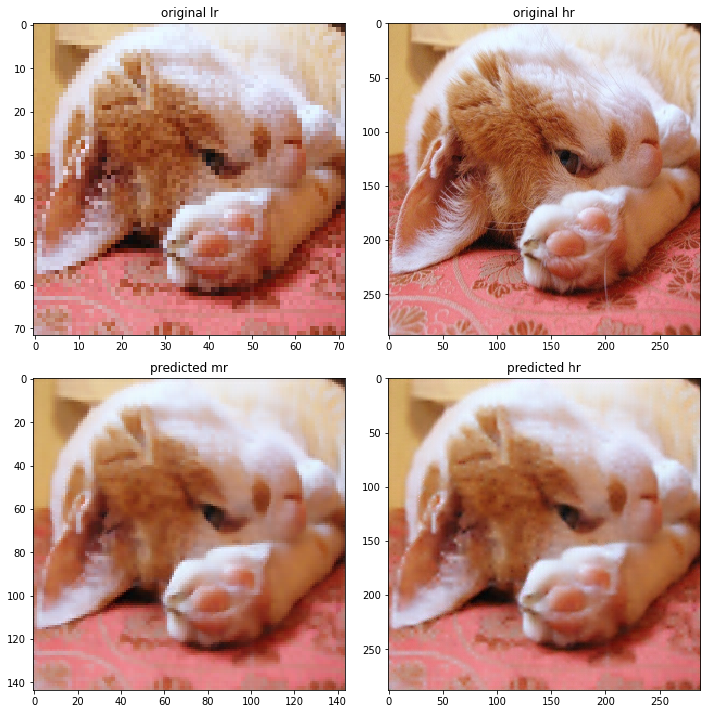

In [49]:
check_image(model, 664, version=2)